In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from sqlalchemy import create_engine
import psycopg2
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# Loading Data 

In [2]:
dim_prod=pd.read_csv("MMA_Dim_Product_Ad.csv")
dim_manu=pd.read_csv("MMA_Dim_Manufacturer_ad.csv")
campaign=pd.read_csv("MMA_DW_Fact_AdGroup_1yr.csv")
daily_sales=pd.read_csv("MMA_ProductSalesDailySnapshot_7months.csv")
HCT=pd.read_csv("HCT_segments.csv")

/var/folders/yr/_4bfz85102x0m0rt6cbvs0hc0000gn/T/ipykernel_33643/3325431927.py:3: DtypeWarning: Columns (1,11) have mixed types. Specify dtype option on import or set low_memory=False.
  campaign=pd.read_csv("MMA_DW_Fact_AdGroup_1yr.csv")


# Importing Data to SQL

In [3]:
#Import all the files into an existing sql database

def write_dataframe_to_table(database_name, user, password, host, port, table_name, dataframe):
    try:
        # Create the PostgreSQL database engine
        connection_string = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database_name}"
        engine = create_engine(connection_string)

        # Write the DataFrame to a new table in the database
        dataframe.to_sql(table_name, engine, if_exists='replace', index=False)

        print(f"DataFrame written to '{table_name}' in '{database_name}' successfully.")
    except Exception as e:
        print(f"Error writing DataFrame to table: {e}")

In [4]:
#write_dataframe_to_table('Cymax', 'postgres', '5008', 'localhost', '5432', 'dim_prod', dim_prod)
#write_dataframe_to_table('Cymax', 'postgres', '5008', 'localhost', '5432', 'dim_manu', dim_manu)
#write_dataframe_to_table('Cymax', 'postgres', '5008', 'localhost', '5432', 'campaign', campaign)
#write_dataframe_to_table('Cymax', 'postgres', '5008', 'localhost', '5432', 'daily_sales', daily_sales)

# EDA & Cleaning

### Daily Sales

In [5]:
daily_sales

,Date,IdProduct,IdManufacturer,IdCategoryLevel5,IsAvailable,IsAvailableOnPromo,MarketingCost,QuantitySold,GrossSales,MarketingCostAmazon,QuantitySoldAmazon,GrossSalesAmazon,BuyBoxPercentAmazon,MarketingCostWebsites,QuantitySoldWebsites,GrossSalesWebsites,LastUpdated,GrossSalesWalmart,QuantitySoldWalmart,MarketingCostWalmart,GrossSalesOtherMPLs,QuantitySoldOtherMPLs,MarketingCostOtherMPLs,PriceWebsites,PriceAmazon,BBWalmart,PriceWalmart
0,2022-03-01,198762,117,292,1,0,0.00,0,0.00,0.0,0,0.0,0.00,0.00,0,0.0,2022-03-30 12:00:01,0.00,0,0.0,0.0,0,0.0,267.99,267.47,NaN,NaN
1,2022-03-01,198985,699,100210,1,0,0.00,0,0.00,0.0,0,0.0,0.00,0.00,0,0.0,2022-03-30 12:00:01,0.00,0,0.0,0.0,0,0.0,1075.99,1075.87,NaN,NaN
2,2022-03-01,204014,43,568,1,1,0.11,0,0.00,0.0,0,0.0,0.00,0.11,0,0.0,2022-03-30 12:00:01,0.00,0,0.0,0.0,0,0.0,158.99,158.99,NaN,NaN
3,2022-03-01,207288,21,298,1,0,0.00,0,0.00,0.0,0,0.0,0.00,0.00,0,0.0,2022-03-30 12:00:01,0.00,0,0.0,0.0,0,0.0,103.99,98.51,NaN,NaN
4,2022-03-01,209234,1470,632,0,0,0.00,0,0.00,0.0,0,0.0,0.00,0.00,0,0.0,2022-03-30 12:00:01,0.00,0,0.0,0.0,0,0.0,433.99,499.84,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21218683,2022-04-20,1967703,3885,577,0,0,0.00,0,0.00,0.0,0,0.0,0.00,0.00,0,0.0,2022-05-19 12:00:01,0.00,0,0.0,0.0,0,0.0,363.99,336.93,NaN,NaN
21218684,2022-04-20,1967738,3885,568,1,0,0.00,2,153.54,0.0,0,0.0,0.00,0.00,0,0.0,2022-05-19 12:00:01,153.54,2,0.0,0.0,0,0.0,84.99,82.22,1.0,76.77
21218685,2022-04-20,1967875,5087,339,1,0,0.00,0,0.00,0.0,0,0.0,0.92,0.00,0,0.0,2022-05-19 12:00:01,0.00,0,0.0,0.0,0,0.0,296.99,296.89,1.0,259.32
21218686,2022-04-20,1967763,5066,100748,1,0,0.00,0,0.00,0.0,0,0.0,0.00,0.00,0,0.0,2022-05-19 12:00:01,0.00,0,0.0,0.0,0,0.0,33.99,32.81,0.0,32.84


In [6]:
#Reorder columns
new_order=['Date','IdProduct','IdManufacturer','IdCategoryLevel5','IsAvailable','IsAvailableOnPromo','LastUpdated','MarketingCost','MarketingCostAmazon','MarketingCostWalmart','MarketingCostWebsites','MarketingCostOtherMPLs','QuantitySold','QuantitySoldAmazon',"QuantitySoldWalmart",'QuantitySoldWebsites','QuantitySoldOtherMPLs',"GrossSales",'GrossSalesAmazon','GrossSalesWalmart','GrossSalesWebsites','GrossSalesOtherMPLs','PriceWebsites','PriceAmazon','PriceWalmart','BBWalmart','BuyBoxPercentAmazon']
daily_sales = daily_sales.reindex(columns=new_order)
daily_sales

,Date,IdProduct,IdManufacturer,IdCategoryLevel5,IsAvailable,IsAvailableOnPromo,LastUpdated,MarketingCost,MarketingCostAmazon,MarketingCostWalmart,MarketingCostWebsites,MarketingCostOtherMPLs,QuantitySold,QuantitySoldAmazon,QuantitySoldWalmart,QuantitySoldWebsites,QuantitySoldOtherMPLs,GrossSales,GrossSalesAmazon,GrossSalesWalmart,GrossSalesWebsites,GrossSalesOtherMPLs,PriceWebsites,PriceAmazon,PriceWalmart,BBWalmart,BuyBoxPercentAmazon
0,2022-03-01,198762,117,292,1,0,2022-03-30 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.00,0.0,0.00,0.0,0.0,267.99,267.47,NaN,NaN,0.00
1,2022-03-01,198985,699,100210,1,0,2022-03-30 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.00,0.0,0.00,0.0,0.0,1075.99,1075.87,NaN,NaN,0.00
2,2022-03-01,204014,43,568,1,1,2022-03-30 12:00:01,0.11,0.0,0.0,0.11,0.0,0,0,0,0,0,0.00,0.0,0.00,0.0,0.0,158.99,158.99,NaN,NaN,0.00
3,2022-03-01,207288,21,298,1,0,2022-03-30 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.00,0.0,0.00,0.0,0.0,103.99,98.51,NaN,NaN,0.00
4,2022-03-01,209234,1470,632,0,0,2022-03-30 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.00,0.0,0.00,0.0,0.0,433.99,499.84,NaN,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21218683,2022-04-20,1967703,3885,577,0,0,2022-05-19 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.00,0.0,0.00,0.0,0.0,363.99,336.93,NaN,NaN,0.00
21218684,2022-04-20,1967738,3885,568,1,0,2022-05-19 12:00:01,0.00,0.0,0.0,0.00,0.0,2,0,2,0,0,153.54,0.0,153.54,0.0,0.0,84.99,82.22,76.77,1.0,0.00
21218685,2022-04-20,1967875,5087,339,1,0,2022-05-19 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.00,0.0,0.00,0.0,0.0,296.99,296.89,259.32,1.0,0.92
21218686,2022-04-20,1967763,5066,100748,1,0,2022-05-19 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.00,0.0,0.00,0.0,0.0,33.99,32.81,32.84,0.0,0.00


In [7]:
daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21218688 entries, 0 to 21218687
Data columns (total 27 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Date                    object 
 1   IdProduct               int64  
 2   IdManufacturer          int64  
 3   IdCategoryLevel5        int64  
 4   IsAvailable             int64  
 5   IsAvailableOnPromo      int64  
 6   LastUpdated             object 
 7   MarketingCost           float64
 8   MarketingCostAmazon     float64
 9   MarketingCostWalmart    float64
 10  MarketingCostWebsites   float64
 11  MarketingCostOtherMPLs  float64
 12  QuantitySold            int64  
 13  QuantitySoldAmazon      int64  
 14  QuantitySoldWalmart     int64  
 15  QuantitySoldWebsites    int64  
 16  QuantitySoldOtherMPLs   int64  
 17  GrossSales              float64
 18  GrossSalesAmazon        float64
 19  GrossSalesWalmart       float64
 20  GrossSalesWebsites      float64
 21  GrossSalesOtherMPLs     float

In [8]:
#converting data types
daily_sales["Date"]=pd.to_datetime(daily_sales["Date"])
daily_sales["LastUpdated"]=pd.to_datetime(daily_sales["LastUpdated"])

In [9]:
#There is a negative marekting cost ! why is a negative ? maybe a typo ?
daily_sales.describe()

,IdProduct,IdManufacturer,IdCategoryLevel5,IsAvailable,IsAvailableOnPromo,MarketingCost,MarketingCostAmazon,MarketingCostWalmart,MarketingCostWebsites,MarketingCostOtherMPLs,QuantitySold,QuantitySoldAmazon,QuantitySoldWalmart,QuantitySoldWebsites,QuantitySoldOtherMPLs,GrossSales,GrossSalesAmazon,GrossSalesWalmart,GrossSalesWebsites,GrossSalesOtherMPLs,PriceWebsites,PriceAmazon,PriceWalmart,BBWalmart,BuyBoxPercentAmazon
count,2.121869e+07,2.121869e+07,2.121869e+07,2.121869e+07,2.121869e+07,2.121869e+07,2.121869e+07,2.121869e+07,2.121869e+07,21218688.0,2.121869e+07,2.121869e+07,2.121869e+07,2.121869e+07,2.121869e+07,2.121869e+07,2.121869e+07,2.121869e+07,2.121869e+07,2.121869e+07,1.994304e+07,1.994304e+07,1.343378e+07,1.421629e+07,2.121869e+07
mean,1.862210e+06,3.710854e+03,1.249875e+04,7.315337e-01,1.820909e-01,2.627849e-01,1.186318e-01,4.330490e-03,1.237232e-01,0.0,2.616576e-02,1.593925e-02,5.185099e-03,2.774771e-03,2.266634e-03,7.912956e+00,4.747475e+00,1.345445e+00,1.079509e+00,7.405275e-01,4.939345e+02,4.944041e+02,4.784241e+02,3.985978e-01,1.466303e-01
std,5.451874e+05,1.854500e+03,3.227090e+04,4.431615e-01,3.859194e-01,3.485135e+00,2.404407e+00,4.433601e-01,1.917445e+00,0.0,3.665580e-01,3.007258e-01,1.112551e-01,9.169589e-02,6.784068e-02,1.155729e+02,9.355430e+01,3.198564e+01,3.727983e+01,2.509206e+01,5.753059e+02,5.794511e+02,5.550186e+02,4.883430e-01,2.951366e-01
min,1.100000e+02,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.000000e-01,-3.000000e-01,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.099000e+01,7.870000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.766028e+06,3.642000e+03,4.260000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.689900e+02,1.669900e+02,1.633400e+02,0.000000e+00,0.000000e+00
50%,1.983992e+06,4.670000e+03,6.260000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.969900e+02,2.957200e+02,2.884500e+02,0.000000e+00,0.000000e+00
75%,2.195525e+06,5.053000e+03,1.019000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.869900e+02,5.853800e+02,5.685100e+02,1.000000e+00,0.000000e+00
max,2.599380e+06,5.935000e+03,1.009580e+05,1.000000e+00,1.000000e+00,4.171770e+03,3.552630e+03,5.588800e+02,8.088100e+02,0.0,1.640000e+02,1.640000e+02,4.100000e+01,1.000000e+02,3.200000e+01,7.583849e+04,7.334229e+04,8.414060e+03,2.280000e+04,9.519260e+03,1.272199e+04,1.272199e+04,1.272199e+04,1.000000e+00,1.900000e+00


In [10]:
#row with -ve marketing cost
daily_sales[daily_sales['MarketingCost']<0]

,Date,IdProduct,IdManufacturer,IdCategoryLevel5,IsAvailable,IsAvailableOnPromo,LastUpdated,MarketingCost,MarketingCostAmazon,MarketingCostWalmart,MarketingCostWebsites,MarketingCostOtherMPLs,QuantitySold,QuantitySoldAmazon,QuantitySoldWalmart,QuantitySoldWebsites,QuantitySoldOtherMPLs,GrossSales,GrossSalesAmazon,GrossSalesWalmart,GrossSalesWebsites,GrossSalesOtherMPLs,PriceWebsites,PriceAmazon,PriceWalmart,BBWalmart,BuyBoxPercentAmazon
4904746,2022-04-22,1444414,4670,914,1,0,2022-05-21 12:00:04,-0.23,-0.23,0.0,0.0,0.0,0,0,0,0,0,0.00,0.0,0.0,0.0,0.00,1513.99,1531.41,1456.92,1.0,0.99
8631402,2022-06-06,1770748,3970,1230,1,0,2022-07-05 12:41:45,-0.02,-0.02,0.0,0.0,0.0,0,0,0,0,0,0.00,0.0,0.0,0.0,0.00,431.99,432.00,NaN,NaN,0.17
10373975,2022-06-22,1770752,3970,1230,1,0,2022-07-21 12:52:27,-0.22,-0.22,0.0,0.0,0.0,1,0,0,0,1,435.83,0.0,0.0,0.0,435.83,407.99,419.07,419.07,0.0,0.96
21043786,2022-09-29,2116503,5268,696,1,0,2022-10-28 11:21:39,-0.30,-0.30,0.0,0.0,0.0,0,0,0,0,0,0.00,0.0,0.0,0.0,0.00,967.99,965.08,965.08,0.0,0.00


In [11]:
#Apply absolute value to the marketing columns
daily_sales[['MarketingCost','MarketingCostAmazon']]=daily_sales[['MarketingCost','MarketingCostAmazon']].abs()


In [12]:
print ('\033[1mData collection start:\033[0m', min(daily_sales["Date"]), '\033[1muntil:\033[0m',max(daily_sales["Date"]))


Data collection start: 2022-03-01 00:00:00 until: 2022-09-30 00:00:00


In [13]:
#checking for missing values
daily_sales.isnull().sum()

Date                            0
IdProduct                       0
IdManufacturer                  0
IdCategoryLevel5                0
IsAvailable                     0
IsAvailableOnPromo              0
LastUpdated                     0
MarketingCost                   0
MarketingCostAmazon             0
MarketingCostWalmart            0
MarketingCostWebsites           0
MarketingCostOtherMPLs          0
QuantitySold                    0
QuantitySoldAmazon              0
QuantitySoldWalmart             0
QuantitySoldWebsites            0
QuantitySoldOtherMPLs           0
GrossSales                      0
GrossSalesAmazon                0
GrossSalesWalmart               0
GrossSalesWebsites              0
GrossSalesOtherMPLs             0
PriceWebsites             1275653
PriceAmazon               1275653
PriceWalmart              7784904
BBWalmart                 7002402
BuyBoxPercentAmazon             0
dtype: int64

In [14]:
#Rows will all 3 prices missing
daily_sales[daily_sales.PriceAmazon.isnull() & daily_sales.PriceWalmart.isnull() & daily_sales.PriceWebsites.isnull()]


,Date,IdProduct,IdManufacturer,IdCategoryLevel5,IsAvailable,IsAvailableOnPromo,LastUpdated,MarketingCost,MarketingCostAmazon,MarketingCostWalmart,MarketingCostWebsites,MarketingCostOtherMPLs,QuantitySold,QuantitySoldAmazon,QuantitySoldWalmart,QuantitySoldWebsites,QuantitySoldOtherMPLs,GrossSales,GrossSalesAmazon,GrossSalesWalmart,GrossSalesWebsites,GrossSalesOtherMPLs,PriceWebsites,PriceAmazon,PriceWalmart,BBWalmart,BuyBoxPercentAmazon
14,2022-03-01,284006,6,100210,0,0,2022-03-30 12:00:01,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
18,2022-03-01,343179,5,224,0,0,2022-03-30 12:00:01,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
35,2022-03-01,12516,60,567,0,0,2022-03-30 12:00:01,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
39,2022-03-01,13888,3830,279,0,0,2022-03-30 12:00:01,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
42,2022-03-01,528593,26,224,0,0,2022-03-30 12:00:01,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21218544,2022-04-20,1966595,3684,680,0,0,2022-05-19 12:00:01,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
21218545,2022-04-20,1966607,4991,997,0,0,2022-05-19 12:00:01,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
21218609,2022-04-20,1966814,3869,997,0,0,2022-05-19 12:00:01,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0
21218632,2022-04-20,1966616,4991,331,0,0,2022-05-19 12:00:01,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0


In [15]:
# percentage of missing values 
( daily_sales.isnull().sum() / len(daily_sales) ) *100

Date                       0.000000
IdProduct                  0.000000
IdManufacturer             0.000000
IdCategoryLevel5           0.000000
IsAvailable                0.000000
IsAvailableOnPromo         0.000000
LastUpdated                0.000000
MarketingCost              0.000000
MarketingCostAmazon        0.000000
MarketingCostWalmart       0.000000
MarketingCostWebsites      0.000000
MarketingCostOtherMPLs     0.000000
QuantitySold               0.000000
QuantitySoldAmazon         0.000000
QuantitySoldWalmart        0.000000
QuantitySoldWebsites       0.000000
QuantitySoldOtherMPLs      0.000000
GrossSales                 0.000000
GrossSalesAmazon           0.000000
GrossSalesWalmart          0.000000
GrossSalesWebsites         0.000000
GrossSalesOtherMPLs        0.000000
PriceWebsites              6.011932
PriceAmazon                6.011932
PriceWalmart              36.688904
BBWalmart                 33.001107
BuyBoxPercentAmazon        0.000000
dtype: float64

array([[<AxesSubplot: title={'center': 'Date'}>,
        <AxesSubplot: title={'center': 'IdProduct'}>,
        <AxesSubplot: title={'center': 'IdManufacturer'}>,
        <AxesSubplot: title={'center': 'IdCategoryLevel5'}>,
        <AxesSubplot: title={'center': 'IsAvailable'}>],
       [<AxesSubplot: title={'center': 'IsAvailableOnPromo'}>,
        <AxesSubplot: title={'center': 'LastUpdated'}>,
        <AxesSubplot: title={'center': 'MarketingCost'}>,
        <AxesSubplot: title={'center': 'MarketingCostAmazon'}>,
        <AxesSubplot: title={'center': 'MarketingCostWalmart'}>],
       [<AxesSubplot: title={'center': 'MarketingCostWebsites'}>,
        <AxesSubplot: title={'center': 'MarketingCostOtherMPLs'}>,
        <AxesSubplot: title={'center': 'QuantitySold'}>,
        <AxesSubplot: title={'center': 'QuantitySoldAmazon'}>,
        <AxesSubplot: title={'center': 'QuantitySoldWalmart'}>],
       [<AxesSubplot: title={'center': 'QuantitySoldWebsites'}>,
        <AxesSubplot: title={'

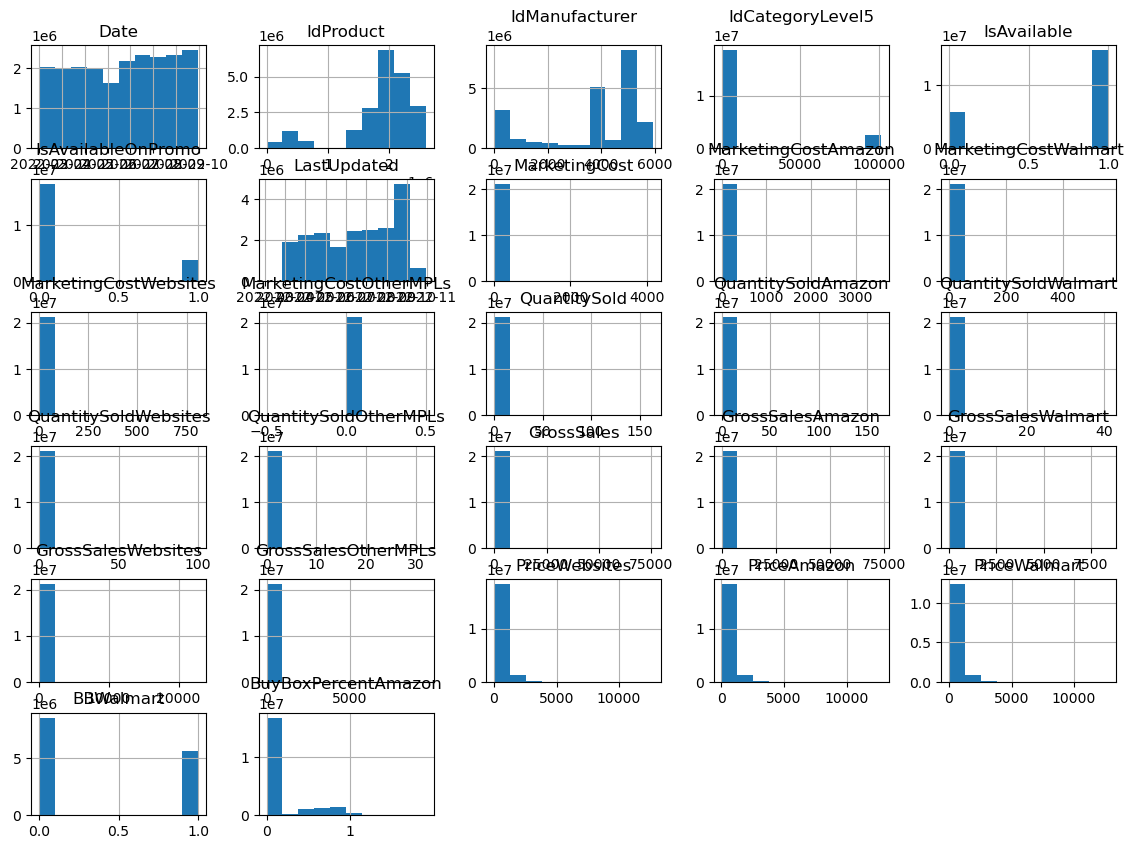

In [16]:
daily_sales.hist(figsize=(14,10))

In [17]:
#checking for duplcate rows
daily_sales.duplicated().sum()

0

In [18]:
#A lot of orders orders have zero quantity sold ! 
daily_sales[daily_sales['QuantitySold']==0]

,Date,IdProduct,IdManufacturer,IdCategoryLevel5,IsAvailable,IsAvailableOnPromo,LastUpdated,MarketingCost,MarketingCostAmazon,MarketingCostWalmart,MarketingCostWebsites,MarketingCostOtherMPLs,QuantitySold,QuantitySoldAmazon,QuantitySoldWalmart,QuantitySoldWebsites,QuantitySoldOtherMPLs,GrossSales,GrossSalesAmazon,GrossSalesWalmart,GrossSalesWebsites,GrossSalesOtherMPLs,PriceWebsites,PriceAmazon,PriceWalmart,BBWalmart,BuyBoxPercentAmazon
0,2022-03-01,198762,117,292,1,0,2022-03-30 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,267.99,267.47,NaN,NaN,0.00
1,2022-03-01,198985,699,100210,1,0,2022-03-30 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1075.99,1075.87,NaN,NaN,0.00
2,2022-03-01,204014,43,568,1,1,2022-03-30 12:00:01,0.11,0.0,0.0,0.11,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,158.99,158.99,NaN,NaN,0.00
3,2022-03-01,207288,21,298,1,0,2022-03-30 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,103.99,98.51,NaN,NaN,0.00
4,2022-03-01,209234,1470,632,0,0,2022-03-30 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,433.99,499.84,NaN,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21218682,2022-04-20,1967670,3885,331,0,0,2022-05-19 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,505.99,505.93,NaN,NaN,0.00
21218683,2022-04-20,1967703,3885,577,0,0,2022-05-19 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,363.99,336.93,NaN,NaN,0.00
21218685,2022-04-20,1967875,5087,339,1,0,2022-05-19 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,296.99,296.89,259.32,1.0,0.92
21218686,2022-04-20,1967763,5066,100748,1,0,2022-05-19 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,33.99,32.81,32.84,0.0,0.00


In [19]:
#These rows have a big chuck of the columns as zeros !
daily_sales[daily_sales['QuantitySold']==0].describe()


,IdProduct,IdManufacturer,IdCategoryLevel5,IsAvailable,IsAvailableOnPromo,MarketingCost,MarketingCostAmazon,MarketingCostWalmart,MarketingCostWebsites,MarketingCostOtherMPLs,QuantitySold,QuantitySoldAmazon,QuantitySoldWalmart,QuantitySoldWebsites,QuantitySoldOtherMPLs,GrossSales,GrossSalesAmazon,GrossSalesWalmart,GrossSalesWebsites,GrossSalesOtherMPLs,PriceWebsites,PriceAmazon,PriceWalmart,BBWalmart,BuyBoxPercentAmazon
count,2.090454e+07,2.090454e+07,2.090454e+07,2.090454e+07,2.090454e+07,2.090454e+07,2.090454e+07,20904536.0,2.090454e+07,20904536.0,20904536.0,20904536.0,20904536.0,20904536.0,20904536.0,20904536.0,20904536.0,20904536.0,20904536.0,20904536.0,1.962890e+07,1.962890e+07,1.321000e+07,1.399250e+07,2.090454e+07
mean,1.864003e+06,3.722370e+03,1.249605e+04,7.274992e-01,1.799493e-01,1.676374e-01,7.641173e-02,0.0,7.811834e-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.962294e+02,4.967811e+02,4.806755e+02,3.974678e-01,1.451337e-01
std,5.424886e+05,1.848081e+03,3.226675e+04,4.452461e-01,3.841452e-01,1.413891e+00,9.069880e-01,0.0,9.594401e-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.778506e+02,5.820132e+02,5.575407e+02,4.881357e-01,2.938428e-01
min,1.100000e+02,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.099000e+01,7.870000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.767546e+06,3.642000e+03,4.260000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.689900e+02,1.670900e+02,1.636100e+02,0.000000e+00,0.000000e+00
50%,1.984121e+06,4.670000e+03,6.320000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.979900e+02,2.969900e+02,2.894100e+02,0.000000e+00,0.000000e+00
75%,2.195505e+06,5.053000e+03,1.019000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.909900e+02,5.893500e+02,5.719900e+02,1.000000e+00,0.000000e+00
max,2.599380e+06,5.935000e+03,1.009580e+05,1.000000e+00,1.000000e+00,8.658900e+02,8.650900e+02,0.0,5.311600e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.272199e+04,1.272199e+04,1.272199e+04,1.000000e+00,1.900000e+00


In [20]:
# % of transactions with no sold items (98.52%)
result = (len(daily_sales[daily_sales['QuantitySold']==0]) / len(daily_sales) ) * 100
result = "{:.9g}".format(result)
print(result)


98.5194561


In [21]:
#Add a "Purchase" column to classify a purchase transaction from browsing one
daily_sales['Purchase'] = np.where(daily_sales['QuantitySold'] > 0, 1, 0)


In [22]:
#Create a separate table for them (these rows only have marekting cost and specifically on amazon & Cymax websites)
#These products were put in the cart on amazon/Cymax websites or maybe opened by the user but NOT BOUGHT
#daily_sales_zero_sold= daily_sales[daily_sales['QuantitySold']==0]
#daily_sales_zero_sold.reset_index(inplace=True,drop=True)
#daily_sales_zero_sold.drop(['QuantitySold','GrossSales','QuantitySoldAmazon','GrossSalesAmazon','QuantitySoldWebsites','GrossSalesWebsites','GrossSalesWalmart','QuantitySoldWalmart','GrossSalesOtherMPLs','QuantitySoldOtherMPLs'],axis=1,inplace=True)
#daily_sales_zero_sold

In [23]:
#sns.heatmap(daily_sales_zero_sold.corr(), annot=True, cmap='coolwarm')

In [24]:
#Price Variables  are highly corrolated
#price amazon : price websites : price walmart  --> drop all keep only one (take median)

#daily_sales_zero_sold["Price"] = daily_sales[['PriceWalmart','PriceAmazon','PriceWebsites']].median(axis=1)
#daily_sales_zero_sold.drop(['PriceWalmart','PriceAmazon','PriceWebsites'],axis=1,inplace=True)


In [25]:
#final table
#daily_sales_zero_sold

In [26]:
#daily_sales_zero_sold.isnull().sum()

In [27]:
#Fill the missing prices from the product dimension table (taking a lot of time)
#for i in range(len(daily_sales_zero_sold)):
    #product_id = daily_sales_zero_sold.loc[i, 'IdProduct']
    #if pd.isnull(daily_sales_zero_sold.loc[i, 'Price']):
        #price = dim_prod.loc[dim_prod['IdProduct'] == product_id, 'price'].values[0]
        #daily_sales_zero_sold.loc[i, 'Price'] = price

In [28]:
#these cost cymax $3.5M in 7 months ! maybe they should not be spent on from the beginning :)
daily_sales[daily_sales.Purchase == 0]['MarketingCost'].sum()

3504382.889999998

In [29]:
#drop all transaction with zero-sold product 
#daily_sales=daily_sales[daily_sales["QuantitySold"] != 0]
#daily_sales.reset_index(inplace=True,drop=True)
#daily_sales

In [30]:
#checking for corrolation
corr_matrix=daily_sales.corr()
corr_matrix[corr_matrix>0.8]

/var/folders/yr/_4bfz85102x0m0rt6cbvs0hc0000gn/T/ipykernel_33643/1372024412.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix=daily_sales.corr()


,IdProduct,IdManufacturer,IdCategoryLevel5,IsAvailable,IsAvailableOnPromo,MarketingCost,MarketingCostAmazon,MarketingCostWalmart,MarketingCostWebsites,MarketingCostOtherMPLs,QuantitySold,QuantitySoldAmazon,QuantitySoldWalmart,QuantitySoldWebsites,QuantitySoldOtherMPLs,GrossSales,GrossSalesAmazon,GrossSalesWalmart,GrossSalesWebsites,GrossSalesOtherMPLs,PriceWebsites,PriceAmazon,PriceWalmart,BBWalmart,BuyBoxPercentAmazon,Purchase
IdProduct,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IdManufacturer,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IdCategoryLevel5,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IsAvailable,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IsAvailableOnPromo,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MarketingCost,NaN,NaN,NaN,NaN,NaN,1.000000,0.816749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MarketingCostAmazon,NaN,NaN,NaN,NaN,NaN,0.816749,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MarketingCostWalmart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MarketingCostWebsites,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MarketingCostOtherMPLs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot: >

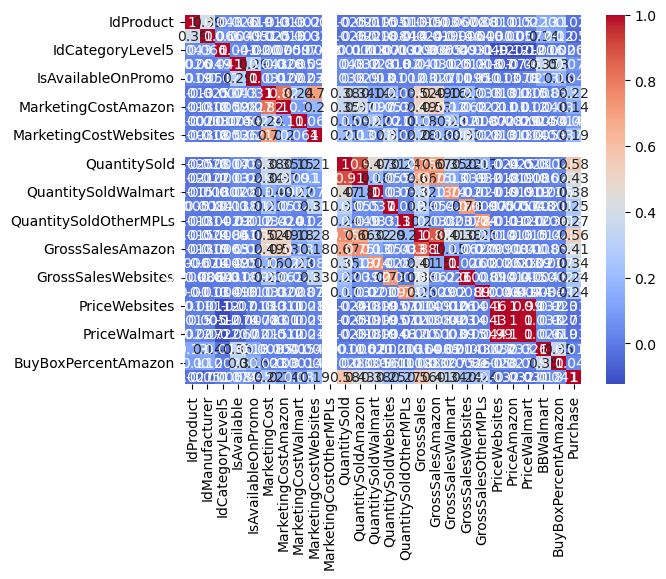

In [31]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [32]:
#Variables that are highly corrolated:
#price amazon : price websites : price walmart  --> combine with one price column

daily_sales["Price"] = daily_sales[['PriceWalmart','PriceAmazon','PriceWebsites']].median(axis=1)
daily_sales.drop(['PriceWalmart','PriceAmazon','PriceWebsites'],axis=1,inplace=True)


In [33]:
#search for outliers (will not drop for now)
zscore_df=stats.zscore(daily_sales.drop(["Date",'LastUpdated'],axis=1))
outliers = daily_sales[(zscore_df >= 3) | (zscore_df <= -3)]
outliers= outliers.dropna(how='all')
outliers



,Date,IdProduct,IdManufacturer,IdCategoryLevel5,IsAvailable,IsAvailableOnPromo,LastUpdated,MarketingCost,MarketingCostAmazon,MarketingCostWalmart,MarketingCostWebsites,MarketingCostOtherMPLs,QuantitySold,QuantitySoldAmazon,QuantitySoldWalmart,QuantitySoldWebsites,QuantitySoldOtherMPLs,GrossSales,GrossSalesAmazon,GrossSalesWalmart,GrossSalesWebsites,GrossSalesOtherMPLs,BBWalmart,BuyBoxPercentAmazon,Purchase,Price
0,NaT,198762.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaT,198985.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaT,204014.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,207288.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaT,209234.0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21218646,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,378.57,NaN,NaN,NaN,378.57,NaN,NaN,1.0,NaN
21218654,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,236.74,NaN,NaN,NaN,NaN,1.0,NaN
21218661,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,530.44,NaN,530.44,NaN,NaN,NaN,NaN,1.0,NaN
21218680,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [34]:
#drop rows with outliers
#daily_sales.drop(outliers.index,inplace=True)
#daily_sales.reset_index(inplace=True,drop=True)

In [35]:
daily_sales

,Date,IdProduct,IdManufacturer,IdCategoryLevel5,IsAvailable,IsAvailableOnPromo,LastUpdated,MarketingCost,MarketingCostAmazon,MarketingCostWalmart,MarketingCostWebsites,MarketingCostOtherMPLs,QuantitySold,QuantitySoldAmazon,QuantitySoldWalmart,QuantitySoldWebsites,QuantitySoldOtherMPLs,GrossSales,GrossSalesAmazon,GrossSalesWalmart,GrossSalesWebsites,GrossSalesOtherMPLs,BBWalmart,BuyBoxPercentAmazon,Purchase,Price
0,2022-03-01,198762,117,292,1,0,2022-03-30 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.00,0.0,0.00,0.0,0.0,NaN,0.00,0,267.730
1,2022-03-01,198985,699,100210,1,0,2022-03-30 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.00,0.0,0.00,0.0,0.0,NaN,0.00,0,1075.930
2,2022-03-01,204014,43,568,1,1,2022-03-30 12:00:01,0.11,0.0,0.0,0.11,0.0,0,0,0,0,0,0.00,0.0,0.00,0.0,0.0,NaN,0.00,0,158.990
3,2022-03-01,207288,21,298,1,0,2022-03-30 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.00,0.0,0.00,0.0,0.0,NaN,0.00,0,101.250
4,2022-03-01,209234,1470,632,0,0,2022-03-30 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.00,0.0,0.00,0.0,0.0,NaN,0.00,0,466.915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21218683,2022-04-20,1967703,3885,577,0,0,2022-05-19 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.00,0.0,0.00,0.0,0.0,NaN,0.00,0,350.460
21218684,2022-04-20,1967738,3885,568,1,0,2022-05-19 12:00:01,0.00,0.0,0.0,0.00,0.0,2,0,2,0,0,153.54,0.0,153.54,0.0,0.0,1.0,0.00,1,82.220
21218685,2022-04-20,1967875,5087,339,1,0,2022-05-19 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.00,0.0,0.00,0.0,0.0,1.0,0.92,0,296.890
21218686,2022-04-20,1967763,5066,100748,1,0,2022-05-19 12:00:01,0.00,0.0,0.0,0.00,0.0,0,0,0,0,0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0,32.840


In [36]:
#Add "Cost per item" and "Cost" columns (from dim_prod table)
daily_sales = daily_sales.merge(dim_prod[['IdProduct', 'cost']], on='IdProduct', how='inner')
daily_sales.rename(columns={'cost': 'Cost_per_item'}, inplace=True)
daily_sales['Cost'] = daily_sales.Cost_per_item * daily_sales.QuantitySold

#Add profit per market place 
for i in ['Amazon','Walmart','Websites','OtherMPLs']:
    daily_sales['Profit'+i]= daily_sales["GrossSales"+i] - daily_sales["MarketingCost"+i] - daily_sales['QuantitySold'+i]*daily_sales['Cost_per_item']
#daily_sales['ProfitWalmart']= daily_sales["GrossSalesWalmart"] - daily_sales["MarketingCostWalmart"]
#daily_sales['ProfitWebsites']= daily_sales["GrossSalesWebsites"] - daily_sales["MarketingCostWebsites"]
#daily_sales['ProfitOtherMPLs']= daily_sales["GrossSalesOtherMPLs"] - daily_sales["MarketingCostOtherMPLs"]

#Add total profit
daily_sales['Profit']= daily_sales["GrossSales"] - daily_sales["MarketingCost"] - daily_sales['Cost']

#Add profit per unit sold 
daily_sales['UnitProfit']= daily_sales['Profit'] / daily_sales.QuantitySold
daily_sales['UnitProfit'].fillna(0, inplace=True)
daily_sales['UnitProfit'] = daily_sales['UnitProfit'].replace(-np.inf, 0)


In [37]:
#There are missing prices --> fill from product table
daily_sales.isnull().sum()

Date                            0
IdProduct                       0
IdManufacturer                  0
IdCategoryLevel5                0
IsAvailable                     0
IsAvailableOnPromo              0
LastUpdated                     0
MarketingCost                   0
MarketingCostAmazon             0
MarketingCostWalmart            0
MarketingCostWebsites           0
MarketingCostOtherMPLs          0
QuantitySold                    0
QuantitySoldAmazon              0
QuantitySoldWalmart             0
QuantitySoldWebsites            0
QuantitySoldOtherMPLs           0
GrossSales                      0
GrossSalesAmazon                0
GrossSalesWalmart               0
GrossSalesWebsites              0
GrossSalesOtherMPLs             0
BBWalmart                 7002402
BuyBoxPercentAmazon             0
Purchase                        0
Price                     1266486
Cost_per_item                   0
Cost                            0
ProfitAmazon                    0
ProfitWalmart 

In [38]:
#Products with missing price
daily_sales[daily_sales['Price'].isnull()][['IdProduct','Price']]

,IdProduct,Price
2239,253752,NaN
2240,253752,NaN
2241,253752,NaN
2242,253752,NaN
2243,253752,NaN
...,...,...
21216158,2571413,NaN
21216159,2571413,NaN
21216160,2571413,NaN
21216740,2599380,NaN


In [39]:
#Fill missing prices from the dim product table
for i in range(len(daily_sales)):
    product_id = daily_sales.loc[i, 'IdProduct']
    if pd.isnull(daily_sales.loc[i, 'Price']):
        price = dim_prod.loc[dim_prod['IdProduct'] == product_id, 'price'].values[0]
        daily_sales.loc[i, 'Price'] = price

In [40]:
#final clean table
daily_sales

,Date,IdProduct,IdManufacturer,IdCategoryLevel5,IsAvailable,IsAvailableOnPromo,LastUpdated,MarketingCost,MarketingCostAmazon,MarketingCostWalmart,MarketingCostWebsites,MarketingCostOtherMPLs,QuantitySold,QuantitySoldAmazon,QuantitySoldWalmart,QuantitySoldWebsites,QuantitySoldOtherMPLs,GrossSales,GrossSalesAmazon,GrossSalesWalmart,GrossSalesWebsites,GrossSalesOtherMPLs,BBWalmart,BuyBoxPercentAmazon,Purchase,Price,Cost_per_item,Cost,ProfitAmazon,ProfitWalmart,ProfitWebsites,ProfitOtherMPLs,Profit,UnitProfit
0,2022-03-01,198762,117,292,1,0,2022-03-30 12:00:01,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,0.00,0,267.73,172.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-03-02,198762,117,292,1,0,2022-03-31 12:04:04,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,0.00,0,267.73,172.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-03-03,198762,117,292,1,0,2022-04-01 12:00:41,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,0.00,0,267.73,172.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-03-05,198762,117,292,1,0,2022-04-03 12:00:01,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,267.47,172.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-03-04,198762,117,292,1,0,2022-04-02 12:05:57,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,267.47,172.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21218683,2022-09-30,2454480,5714,624,1,1,2022-10-29 11:30:20,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,180.84,104.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21218684,2022-09-30,2563968,5898,436,1,0,2022-10-29 11:30:20,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0,204.85,137.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21218685,2022-09-30,2469192,4753,915,0,0,2022-10-29 11:30:20,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,2062.07,1416.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21218686,2022-09-30,2469091,4753,915,1,0,2022-10-29 11:30:20,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.92,0,2798.55,1549.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


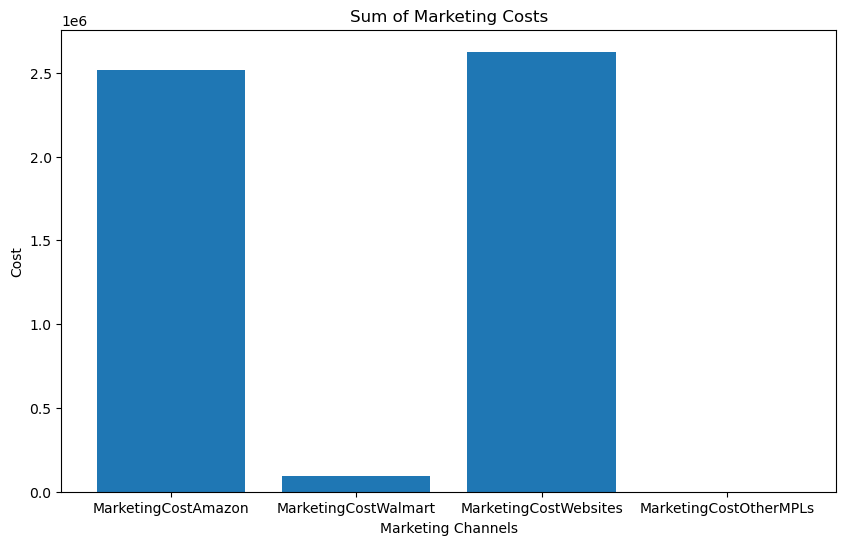

In [41]:
sums=daily_sales[['MarketingCostAmazon','MarketingCostWalmart','MarketingCostWebsites','MarketingCostOtherMPLs']].sum()
plt.figure(figsize=(10,6))
plt.bar(sums.index, sums.values)
plt.title('Sum of Marketing Costs')
plt.xlabel('Marketing Channels')
plt.ylabel('Cost')
plt.show()

In [42]:
#no. unique different products 
len(daily_sales["IdProduct"].unique())

113485

In [43]:
#Unique products (purchased) and no. of transaction for each
df_prod = pd.DataFrame(daily_sales[daily_sales.Purchase ==1].groupby(['IdProduct'])['Date'].count()).rename(columns={'Date':"Count"}).sort_values(by='Count',ascending=False)
df_prod

,Count
IdProduct,
436237,206
435945,205
1975836,204
1988186,204
1786496,201
...,...
2237923,1
1879801,1
2237893,1


In [44]:
#no. Products were bought less than twice within 7 months
(df_prod.Count <= 2).sum()

31594

In [45]:
31594 / 54190 *100

58.30226979147444

In [46]:
#export clean data into a csv to visualize on tableau
daily_sales.to_csv('clean_daily_sales.csv', index=False)


In [47]:
#Which MPL has the most sales:
daily_sales[daily_sales.Purchase==1][["QuantitySoldAmazon",'QuantitySoldWalmart','QuantitySoldWebsites',"QuantitySoldOtherMPLs"]].sum()


QuantitySoldAmazon       338210
QuantitySoldWalmart      110021
QuantitySoldWebsites      58877
QuantitySoldOtherMPLs     48095
dtype: int64

In [48]:
#showing in % of total sold SKUs
(daily_sales[["QuantitySoldAmazon",'QuantitySoldWalmart','QuantitySoldWebsites',"QuantitySoldOtherMPLs"]].sum() / sum(daily_sales["QuantitySold"]) ) *100


QuantitySoldAmazon       60.916458
QuantitySoldWalmart      19.816355
QuantitySoldWebsites     10.604590
QuantitySoldOtherMPLs     8.662597
dtype: float64

In [49]:
#the rest of the graph are done on tableau


In [50]:
#checking if any of the products does not have a campaign status
unique_daily_sales = set(daily_sales['IdProduct'].unique())
unique_dim_prod = set(dim_prod['IdProduct'].unique())

diff = unique_daily_sales.difference(unique_dim_prod)

for i in diff:
    print(i)

In [51]:
#checking if any of the products does not have a row in dim_prod tabe
unique_daily_sales = set(daily_sales['IdProduct'].unique())
unique_campaign = set(campaign['IdProduct'].unique())

diff = unique_daily_sales.difference(unique_dim_prod)

for i in diff:
    print(i)

In [52]:
#checking if any of the products does not have a row in HCT tabe
unique_daily_sales = set(daily_sales['IdProduct'].unique())
unique_HCT = set(HCT['IDPRODUCT'].unique())

diff = unique_daily_sales.difference(unique_HCT)

diff


set()

### Campaign

In [53]:
#campaign=pd.read_csv("MMA_DW_Fact_AdGroup_1yr.csv")

In [54]:
campaign

,Date,Status,idCategoryLevel5,idAccCategoryLevel2,idLocation,IdProduct,idStore,idPaymentType,idSource,idDeviceInfo,idCarrier,AccountID,AccountName,AccountType,AccountStatus,CampaignID,CampaignName,AdGroupID,AdGroup,PPC Cost,PPC Revenue,idAccCategoryLevel2_Main,IdBusinessChannel
0,2021-09-01,Active,0,0,0,0,181,0,9,3,0,F129PHDH,HomeSquare - Bing,Bing Ads,Active,402016901,Search - Home Square - Category - Storage (Broad),1.271036e+15,Drawers - Chest Of,0.00,0.0,0,77
1,2021-09-01,Active,0,0,0,0,181,0,9,3,0,F129PHDH,HomeSquare - Bing,Bing Ads,Active,402016989,Search - HomeSquare - Branded - Exact,1.266638e+15,Homesquare ^ Store,0.00,0.0,0,77
2,2021-09-01,Active,0,0,0,0,181,0,9,3,0,F129PHDH,HomeSquare - Bing,Bing Ads,Active,402380802,Search - HomeSquare - Top Brand - Coaster Furn...,1.261141e+15,Top Brand - Coaster Furniture,0.54,0.0,0,77
3,2021-09-01,Active,0,0,0,0,53,0,9,3,0,F12915JC,Cymax - Bing,Bing Ads,Active,402015557,Search-Cymax-Category-Furniture -General Terms...,1.272136e+15,Sauder - Furniture,0.00,0.0,0,35
4,2021-09-01,Active,0,0,0,0,53,0,9,3,0,F12915JC,Cymax - Bing,Bing Ads,Active,402015564,Search-Cymax-Category- Furniture - General Ter...,1.268837e+15,Bowery Hill,0.48,0.0,0,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12683372,2022-09-30,NaN,624,178,0,2397855,0,43,36,0,0,0,Walmart,Walmart,Active,0,Pacvue - Auto - MB - Carl,0.000000e+00,Bar Stools,0.00,0.0,178,192
12683373,2022-09-30,NaN,624,178,0,2397855,0,43,36,0,0,0,Walmart,Walmart,Active,0,Pacvue - Home - Furniture - Kitchen & Dining F...,0.000000e+00,Kitchen & Dining Furniture - 12,0.00,0.0,178,192
12683374,2022-09-30,NaN,568,334,0,1791202,0,43,36,0,0,0,Walmart,Walmart,Active,0,Pacvue - Auto - MB - Carl,0.000000e+00,End Tables,0.20,0.0,334,192
12683375,2022-09-30,NaN,689,673,0,2116295,0,43,36,0,0,0,Walmart,Walmart,Active,0,Pacvue - Home - Furniture - Kitchen & Dining F...,0.000000e+00,Kitchen & Dining Furniture - 10,0.00,0.0,673,192


In [55]:
#convert date into datetime data type
campaign["Date"]=pd.to_datetime(campaign["Date"])


In [56]:
campaign.isnull().sum()

Date                              0
Status                      9328552
idCategoryLevel5                  0
idAccCategoryLevel2               0
idLocation                        0
IdProduct                         0
idStore                           0
idPaymentType                     0
idSource                          0
idDeviceInfo                      0
idCarrier                         0
AccountID                       128
AccountName                       0
AccountType                       0
AccountStatus                     0
CampaignID                        0
CampaignName                      0
AdGroupID                    452058
AdGroup                      452059
PPC Cost                          0
PPC Revenue                       0
idAccCategoryLevel2_Main          0
IdBusinessChannel                 0
dtype: int64

In [57]:
# percentage of missing values 
( campaign.isnull().sum() / len(campaign) ) *100

Date                         0.000000
Status                      73.549434
idCategoryLevel5             0.000000
idAccCategoryLevel2          0.000000
idLocation                   0.000000
IdProduct                    0.000000
idStore                      0.000000
idPaymentType                0.000000
idSource                     0.000000
idDeviceInfo                 0.000000
idCarrier                    0.000000
AccountID                    0.001009
AccountName                  0.000000
AccountType                  0.000000
AccountStatus                0.000000
CampaignID                   0.000000
CampaignName                 0.000000
AdGroupID                    3.564177
AdGroup                      3.564185
PPC Cost                     0.000000
PPC Revenue                  0.000000
idAccCategoryLevel2_Main     0.000000
IdBusinessChannel            0.000000
dtype: float64

In [58]:
#what classes does each cat. variable carry ? 
cat=['Status','AccountID','AccountName','AccountType','AccountStatus','CampaignName','AdGroup']
for i in cat:
    print(f"{i} ({len(campaign[i].unique())}) : {campaign[i].unique()} \n")

Status (7) : ['Active' 'removed' nan 'Paused' 'ACTIVE' 'PAUSED' 'Deleted'] 

AccountID (12) : ['F129PHDH' 'F12915JC' 'F129FEZF' '517-609-2664' '771-076-1355'
 '690-338-5028' '768-699-1310' '719-763-5286' '0' 0 '150579838399879' nan] 

AccountName (11) : ['HomeSquare - Bing' 'Cymax - Bing' 'Bush Business Furniture - Bing'
 'FireSale' 'Home Square B2C' 'Main - B2B Cymax' 'Shopping PLA'
 'Bush Business Furniture' 'Amazon Market' 'Walmart' 'Cymax'] 

AccountType (5) : ['Bing Ads' 'Google AdWords' 'Amazon Market' 'Walmart' 'Facebook Ads'] 

AccountStatus (1) : ['Active'] 

CampaignName (2579) : ['Search - Home Square - Category - Storage (Broad)'
 'Search - HomeSquare - Branded - Exact'
 'Search - HomeSquare - Top Brand - Coaster Furniture' ...
 'Steve Silver - PL Only - Jim' 'Shopping - Homesquare - Category - Bed'
 'Shopping - Homesquare - Brand - Home Square'] 

AdGroup (12328) : ['Drawers - Chest Of' 'Homesquare ^ Store' 'Top Brand - Coaster Furniture'
 ... 'Headboards - 1982207 - PR 22

In [59]:
#How many campaigns with account ID 0 ? or '0' (9.3M ! most of them lol)
campaign[(campaign.AccountID == 0) | (campaign.AccountID == '0')]


,Date,Status,idCategoryLevel5,idAccCategoryLevel2,idLocation,IdProduct,idStore,idPaymentType,idSource,idDeviceInfo,idCarrier,AccountID,AccountName,AccountType,AccountStatus,CampaignID,CampaignName,AdGroupID,AdGroup,PPC Cost,PPC Revenue,idAccCategoryLevel2_Main,IdBusinessChannel
9702,2021-09-01,NaN,535,347,0,1711841,0,0,6,0,0,0,Amazon Market,Amazon Market,Active,76,DHP - Beds - Automatic - Cymax - Vanessa,137539.0,Ottomans - (new),0.09,0.0,347,3
9703,2021-09-01,NaN,1209,105,0,1831286,0,0,6,0,0,0,Amazon Market,Amazon Market,Active,137,Homesquare MB - Catchall - Automatic - Jim,163324.0,Baby Crib Sets 2018,0.33,0.0,105,3
9704,2021-09-01,NaN,331,226,0,2193928,0,0,6,0,0,0,Amazon Market,Amazon Market,Active,9758,Category Growth - Beds (Queen) - 2021 - Bobby,158304.0,2700+,0.20,0.0,226,3
9705,2021-09-01,NaN,279,373,0,13256,0,0,6,0,0,0,Amazon Market,Amazon Market,Active,200,BBF - Bush - Automatic - CG - Jim,159014.0,Computer Desks 500-1000,3.76,0.0,373,3
9706,2021-09-01,NaN,1042,350,0,1966907,0,0,6,0,0,0,Amazon Market,Amazon Market,Active,10048,LeisureMod - CG - Auto - JJ,158543.0,Kids Rocking Chairs,0.09,0.0,350,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12683372,2022-09-30,NaN,624,178,0,2397855,0,43,36,0,0,0,Walmart,Walmart,Active,0,Pacvue - Auto - MB - Carl,0.0,Bar Stools,0.00,0.0,178,192
12683373,2022-09-30,NaN,624,178,0,2397855,0,43,36,0,0,0,Walmart,Walmart,Active,0,Pacvue - Home - Furniture - Kitchen & Dining F...,0.0,Kitchen & Dining Furniture - 12,0.00,0.0,178,192
12683374,2022-09-30,NaN,568,334,0,1791202,0,43,36,0,0,0,Walmart,Walmart,Active,0,Pacvue - Auto - MB - Carl,0.0,End Tables,0.20,0.0,334,192
12683375,2022-09-30,NaN,689,673,0,2116295,0,43,36,0,0,0,Walmart,Walmart,Active,0,Pacvue - Home - Furniture - Kitchen & Dining F...,0.0,Kitchen & Dining Furniture - 10,0.00,0.0,673,192


In [60]:
#Eliminate duplicated classes with same meaning
campaign['Status'] = campaign['Status'].replace({'removed': 'Deleted', 'ACTIVE': 'Active','PAUSED':'Paused','active':'Active'})
campaign['AccountID'] = campaign['AccountID'].replace({'0': np.nan, 0: np.nan})


In [61]:
#check again for duplicated class names
cat=['Status','AccountID','AccountName','AccountType','AccountStatus','CampaignName','AdGroup']
for i in cat:
    print(i,':',campaign[i].unique(), '\n')

Status : ['Active' 'Deleted' nan 'Paused'] 

AccountID : ['F129PHDH' 'F12915JC' 'F129FEZF' '517-609-2664' '771-076-1355'
 '690-338-5028' '768-699-1310' '719-763-5286' nan '150579838399879'] 

AccountName : ['HomeSquare - Bing' 'Cymax - Bing' 'Bush Business Furniture - Bing'
 'FireSale' 'Home Square B2C' 'Main - B2B Cymax' 'Shopping PLA'
 'Bush Business Furniture' 'Amazon Market' 'Walmart' 'Cymax'] 

AccountType : ['Bing Ads' 'Google AdWords' 'Amazon Market' 'Walmart' 'Facebook Ads'] 

AccountStatus : ['Active'] 

CampaignName : ['Search - Home Square - Category - Storage (Broad)'
 'Search - HomeSquare - Branded - Exact'
 'Search - HomeSquare - Top Brand - Coaster Furniture' ...
 'Steve Silver - PL Only - Jim' 'Shopping - Homesquare - Category - Bed'
 'Shopping - Homesquare - Brand - Home Square'] 

AdGroup : ['Drawers - Chest Of' 'Homesquare ^ Store' 'Top Brand - Coaster Furniture'
 ... 'Headboards - 1982207 - PR 220' 'Beds - 2132591 - PR 570'
 'Category - Bed'] 



In [62]:
#what is '150579838399879' in accout id ? an error ? 
campaign[['AccountID','AccountName']].drop_duplicates()


,AccountID,AccountName
0,F129PHDH,HomeSquare - Bing
3,F12915JC,Cymax - Bing
31,F129FEZF,Bush Business Furniture - Bing
521,517-609-2664,FireSale
531,771-076-1355,Home Square B2C
535,690-338-5028,Main - B2B Cymax
544,768-699-1310,Shopping PLA
702,719-763-5286,Bush Business Furniture
9702,NaN,Amazon Market
18881,NaN,Walmart


In [63]:
print("No. Campaigns with Account ID: 150579838399879 -->" ,len(campaign[campaign['AccountID']=='150579838399879']),'\nNo. Campaigns with Acount Name: Cymax & Acount ID: NaN -->' ,len(campaign[(campaign['AccountID'].isnull()) & (campaign['AccountName']=='Cymax')]))


No. Campaigns with Account ID: 150579838399879 --> 9709 
No. Campaigns with Acount Name: Cymax & Acount ID: NaN --> 128


In [64]:
#change account id from NaN into 150579838399879 for campaigns with acount name cymax
campaign.loc[(campaign['AccountID'].isnull()) & (campaign['AccountName'] == 'Cymax'), 'AccountID'] = '150579838399879'


In [65]:
#drop AccountStatus (since its "Active" for all rows)
campaign.drop('AccountStatus',axis=1,inplace=True)

In [66]:
#lets look at the numerical variables
#idLocation and idCarrier are zeros 
campaign.describe()

,idCategoryLevel5,idAccCategoryLevel2,idLocation,IdProduct,idStore,idPaymentType,idSource,idDeviceInfo,idCarrier,CampaignID,AdGroupID,PPC Cost,PPC Revenue,idAccCategoryLevel2_Main,IdBusinessChannel
count,1.268338e+07,1.268338e+07,12683377.0,1.268338e+07,1.268338e+07,1.268338e+07,1.268338e+07,1.268338e+07,12683377.0,1.268338e+07,1.223132e+07,1.268338e+07,1.268338e+07,1.268338e+07,1.268338e+07
mean,1.135884e+04,3.204779e+02,0.0,1.953668e+06,3.743183e+01,1.818765e+01,2.054381e+01,4.117592e-01,0.0,6.611197e+09,1.581914e+13,9.613191e-01,9.034618e+00,2.464726e+02,9.910303e+01
std,3.089795e+04,1.240258e+02,0.0,5.515724e+05,7.311739e+01,2.124331e+01,1.353429e+01,8.126638e-01,0.0,1.754161e+11,1.406161e+14,1.161990e+01,1.179485e+02,1.733831e+02,8.383005e+01
min,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,-4.500000e-01,0.000000e+00,0.000000e+00,3.000000e+00
25%,3.440000e+02,2.310000e+02,0.0,1.825441e+06,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.500000e+01,3.000000e+00
50%,6.260000e+02,3.200000e+02,0.0,2.088854e+06,0.000000e+00,0.000000e+00,1.300000e+01,0.000000e+00,0.0,1.891000e+03,1.380560e+05,2.000000e-01,0.000000e+00,2.920000e+02,7.700000e+01
75%,1.014000e+03,3.650000e+02,0.0,2.302020e+06,5.300000e+01,4.300000e+01,3.600000e+01,0.000000e+00,0.0,1.969887e+09,7.487263e+10,7.400000e-01,0.000000e+00,3.490000e+02,1.920000e+02
max,1.009680e+05,7.650000e+02,0.0,2.646282e+06,1.542000e+03,4.300000e+01,3.600000e+01,3.000000e+00,0.0,6.322644e+12,1.276534e+15,6.894771e+03,7.188516e+04,7.650000e+02,5.760000e+02


In [67]:
#drop idLocation and idCarrier
campaign.drop(['idLocation','idCarrier'],axis=1,inplace=True)

In [68]:
#Why does some products have product Id = zero ?
campaign[campaign.IdProduct==0]

,Date,Status,idCategoryLevel5,idAccCategoryLevel2,IdProduct,idStore,idPaymentType,idSource,idDeviceInfo,AccountID,AccountName,AccountType,CampaignID,CampaignName,AdGroupID,AdGroup,PPC Cost,PPC Revenue,idAccCategoryLevel2_Main,IdBusinessChannel
0,2021-09-01,Active,0,0,0,181,0,9,3,F129PHDH,HomeSquare - Bing,Bing Ads,402016901,Search - Home Square - Category - Storage (Broad),1.271036e+15,Drawers - Chest Of,0.0000,0.0,0,77
1,2021-09-01,Active,0,0,0,181,0,9,3,F129PHDH,HomeSquare - Bing,Bing Ads,402016989,Search - HomeSquare - Branded - Exact,1.266638e+15,Homesquare ^ Store,0.0000,0.0,0,77
2,2021-09-01,Active,0,0,0,181,0,9,3,F129PHDH,HomeSquare - Bing,Bing Ads,402380802,Search - HomeSquare - Top Brand - Coaster Furn...,1.261141e+15,Top Brand - Coaster Furniture,0.5400,0.0,0,77
3,2021-09-01,Active,0,0,0,53,0,9,3,F12915JC,Cymax - Bing,Bing Ads,402015557,Search-Cymax-Category-Furniture -General Terms...,1.272136e+15,Sauder - Furniture,0.0000,0.0,0,35
4,2021-09-01,Active,0,0,0,53,0,9,3,F12915JC,Cymax - Bing,Bing Ads,402015564,Search-Cymax-Category- Furniture - General Ter...,1.268837e+15,Bowery Hill,0.4800,0.0,0,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12682948,2022-09-30,Active,0,0,0,181,0,13,0,771-076-1355,Home Square B2C,Google AdWords,16274034377,Search - HomeSquare - Vendor Brand - 2nd,NaN,NaN,4.9300,0.0,0,77
12682949,2022-09-30,Active,0,0,0,53,0,13,2,768-699-1310,Shopping PLA,Google AdWords,18274576056,PMax: Shopping - Cymax - Brand - Bush,NaN,NaN,7.7563,0.0,0,35
12682950,2022-09-30,Active,0,0,0,53,0,13,0,768-699-1310,Shopping PLA,Google AdWords,13521034945,Search - Cymax -Top Brand - Prepac,NaN,NaN,2.7600,0.0,0,35
12682951,2022-09-30,Active,0,0,0,53,0,13,0,768-699-1310,Shopping PLA,Google AdWords,15109665788,Search - Cymax - Category - Accent Cabinets,NaN,NaN,1.4900,0.0,0,35


In [69]:
campaign[campaign.IdProduct==0].describe()

,idCategoryLevel5,idAccCategoryLevel2,IdProduct,idStore,idPaymentType,idSource,idDeviceInfo,CampaignID,AdGroupID,PPC Cost,PPC Revenue,idAccCategoryLevel2_Main,IdBusinessChannel
count,210475.0,210475.000000,210475.0,210475.000000,210475.000000,210475.000000,210475.000000,2.104750e+05,1.974110e+05,210475.000000,210475.000000,210475.000000,210475.000000
mean,0.0,13.010624,0.0,117.461941,0.157311,13.171598,0.667885,2.977973e+11,9.785949e+14,6.258774,36.177533,13.010847,56.598190
std,0.0,73.097881,0.0,71.101057,2.596084,8.014566,1.130265,1.329303e+12,5.319401e+14,85.918200,471.615080,73.097842,25.385937
min,0.0,0.000000,0.0,0.000000,0.000000,6.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,3.000000
25%,0.0,0.000000,0.0,53.000000,0.000000,9.000000,0.000000,4.023961e+08,1.260041e+15,0.000000,0.000000,0.000000,35.000000
50%,0.0,0.000000,0.0,181.000000,0.000000,9.000000,0.000000,4.024681e+08,1.265539e+15,0.000000,0.000000,0.000000,77.000000
75%,0.0,0.000000,0.0,181.000000,0.000000,13.000000,2.000000,1.071358e+10,1.271036e+15,1.120000,0.000000,0.000000,77.000000
max,0.0,683.000000,0.0,1542.000000,43.000000,36.000000,3.000000,6.322644e+12,1.276534e+15,6894.770600,71885.160000,683.000000,576.000000


In [70]:
#According to product dimension table these products are useless they carry no info 
dim_prod[dim_prod.IdProduct==0]

,IdProduct,IdManufacture,Description,cost,price,listprice,weight,width,height,depth,map,isset,ManufactureGroup,ManufShipsOnCymaxAccount,onPromo,BackOrderDate,createdDate,idCollection,CollectionName,ShippingDaysFrom,ShippingDaysTo,idCategoryLevel5,DescCategoryLevel5,idAccCategoryLevel2,DescAccCategoryLevel2,Active,isDiscontinued,isPrivateLabel,skid_product_source,website_min_margin,amazon_min_margin,FirstActivationDate,LastActivationDate,CountryOfOrigin,IsGround,IsPallet,Stock
12520,0,0,Unknown Product,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,Unknown Manufacturer Group,No,0,NaN,NaN,NaN,NaN,NaN,NaN,0,Unknown Category Level5,0,Unknown AccCategory Level2,0,0,0,6,0.0,0.0,NaN,NaN,NaN,1,0,0


In [71]:
#lets check the daily sales tables
daily_sales[daily_sales.IdProduct ==0]

,Date,IdProduct,IdManufacturer,IdCategoryLevel5,IsAvailable,IsAvailableOnPromo,LastUpdated,MarketingCost,MarketingCostAmazon,MarketingCostWalmart,MarketingCostWebsites,MarketingCostOtherMPLs,QuantitySold,QuantitySoldAmazon,QuantitySoldWalmart,QuantitySoldWebsites,QuantitySoldOtherMPLs,GrossSales,GrossSalesAmazon,GrossSalesWalmart,GrossSalesWebsites,GrossSalesOtherMPLs,BBWalmart,BuyBoxPercentAmazon,Purchase,Price,Cost_per_item,Cost,ProfitAmazon,ProfitWalmart,ProfitWebsites,ProfitOtherMPLs,Profit,UnitProfit


In [72]:
#drop campaigns for products with ID: 0
campaign=campaign[campaign.IdProduct!=0]
campaign.reset_index(inplace=True,drop=True)

In [73]:
#why does a -ve PPC cost mean ? is this a typo ?
campaign[campaign['PPC Cost']<0]

,Date,Status,idCategoryLevel5,idAccCategoryLevel2,IdProduct,idStore,idPaymentType,idSource,idDeviceInfo,AccountID,AccountName,AccountType,CampaignID,CampaignName,AdGroupID,AdGroup,PPC Cost,PPC Revenue,idAccCategoryLevel2_Main,IdBusinessChannel
433923,2021-09-17,NaN,604,339,1994792,0,0,6,0,NaN,Amazon Market,Amazon Market,8348,DHP PL Only - Automatic - PMP - Vanessa,134682.0,Futons,-0.07,0.0,339,3
670635,2021-09-27,NaN,619,228,2008719,0,0,6,0,NaN,Amazon Market,Amazon Market,368,20%+ Club - Branded - Automatic - Cymax - Jim,69532.0,Bunk Beds,-0.28,0.0,228,3
673744,2021-09-27,NaN,919,333,2263847,0,0,6,0,NaN,Amazon Market,Amazon Market,10112,Lexicon - PL Only - Auto - 3% PMP - Bill,160284.0,Convertible Sofas,-0.10,0.0,333,3
906407,2021-10-07,NaN,344,230,2171598,0,0,6,0,NaN,Amazon Market,Amazon Market,9423,RealRooms - Manual - Vanessa,163897.0,Beds - Category,-0.14,0.0,230,3
1029909,2021-10-12,NaN,696,299,2013827,0,0,6,0,NaN,Amazon Market,Amazon Market,368,20%+ Club - Branded - Automatic - Cymax - Jim,69598.0,Dining Sets,-0.28,0.0,299,3
1094404,2021-10-15,NaN,1015,276,1869104,0,0,6,0,NaN,Amazon Market,Amazon Market,9425,Real Flame - Manual - Nicky,142072.0,Electric Fireplaces,-0.19,0.0,276,3
1338341,2021-10-25,NaN,1107,365,2077383,0,0,6,0,NaN,Amazon Market,Amazon Market,10063,Eviva- Auto - 2% PMP - JJ,158942.0,Bathroom Vanities,-0.01,0.0,365,3
1338854,2021-10-25,NaN,914,345,2153680,0,0,6,0,NaN,Amazon Market,Amazon Market,9748,Category Growth - Loveseats - 2021 - Bobby,157839.0,600 - 650,-0.16,0.0,345,3
2818809,2021-12-10,NaN,340,231,2251689,0,0,6,0,NaN,Amazon Market,Amazon Market,8716,Tvilum - Auto - Private Label Only - Vanessa,136917.0,Dressers,-0.16,0.0,231,3
2842156,2021-12-10,NaN,626,300,1987134,0,0,6,0,NaN,Amazon Market,Amazon Market,8742,Category Growth - 2020 - Dining (No Sales No C...,137417.0,Dining Tables,-0.15,0.0,300,3


In [74]:
#Apply absolute value to the PPC Cost columns
campaign['PPC Cost']=campaign['PPC Cost'].abs()


/var/folders/yr/_4bfz85102x0m0rt6cbvs0hc0000gn/T/ipykernel_33643/3000761642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  campaign['PPC Cost']=campaign['PPC Cost'].abs()


In [75]:
#checking for corrolation
corr_matrix=campaign.corr()
corr_matrix[corr_matrix>0.8]

/var/folders/yr/_4bfz85102x0m0rt6cbvs0hc0000gn/T/ipykernel_33643/2665169100.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix=campaign.corr()


,idCategoryLevel5,idAccCategoryLevel2,IdProduct,idStore,idPaymentType,idSource,idDeviceInfo,CampaignID,AdGroupID,PPC Cost,PPC Revenue,idAccCategoryLevel2_Main,IdBusinessChannel
idCategoryLevel5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
idAccCategoryLevel2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IdProduct,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
idStore,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.809743,NaN,NaN,NaN,NaN
idPaymentType,NaN,NaN,NaN,NaN,1.000000,0.981122,NaN,NaN,NaN,NaN,NaN,NaN,0.949979
idSource,NaN,NaN,NaN,NaN,0.981122,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.985025
idDeviceInfo,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.829916,NaN,NaN,NaN,NaN
CampaignID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.874895,NaN,NaN,NaN,NaN
AdGroupID,NaN,NaN,NaN,0.809743,NaN,NaN,0.829916,0.874895,1.000000,NaN,NaN,NaN,NaN
PPC Cost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


<AxesSubplot: >

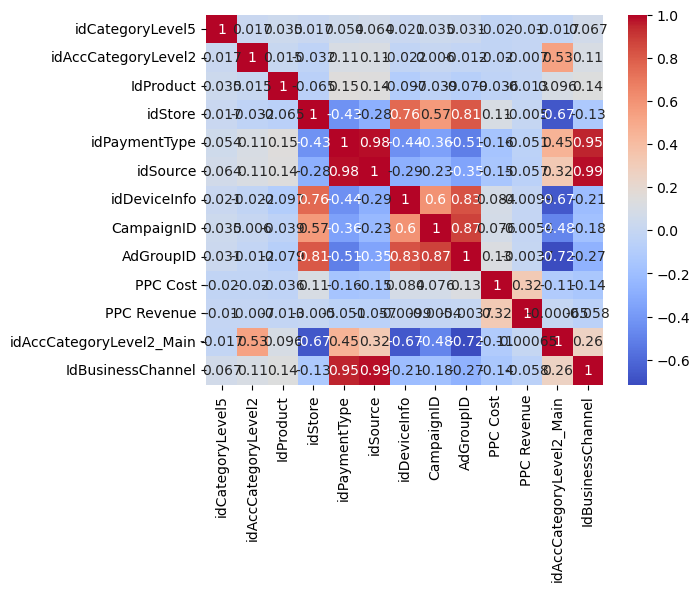

In [76]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [77]:
#Highly correlated variables:
#idSource : idPayment type :idBusiness channel (are always identical)
campaign[['idPaymentType','idSource','IdBusinessChannel']].drop_duplicates()

,idPaymentType,idSource,IdBusinessChannel
0,0,13,576
10,0,13,77
17,0,13,35
175,0,13,19
9097,0,6,3
18271,43,36,192


In [78]:
#just keep idSource
campaign.drop(['idPaymentType','IdBusinessChannel'],axis=1,inplace=True)

/var/folders/yr/_4bfz85102x0m0rt6cbvs0hc0000gn/T/ipykernel_33643/613694160.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  campaign.drop(['idPaymentType','IdBusinessChannel'],axis=1,inplace=True)


In [79]:
#search for outliers (i will not drop them)
zscore_df=stats.zscore(campaign.drop(["Date",'Status','AccountID','AccountName','AccountType','CampaignName','AdGroup'],axis=1))
outliers = campaign[(zscore_df >= 3) | (zscore_df <= -3)]
outliers= outliers.dropna(how='all')
outliers

#there 1451851 rows with outliers

,Date,Status,idCategoryLevel5,idAccCategoryLevel2,IdProduct,idStore,idSource,idDeviceInfo,AccountID,AccountName,AccountType,CampaignID,CampaignName,AdGroupID,AdGroup,PPC Cost,PPC Revenue,idAccCategoryLevel2_Main
0,NaT,NaN,NaN,NaN,NaN,1542.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaT,NaN,NaN,NaN,NaN,1542.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaT,NaN,NaN,NaN,NaN,1542.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,NaN,NaN,763.0,NaN,1542.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaT,NaN,NaN,NaN,NaN,1542.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12472633,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.92,NaN
12472646,NaT,NaN,NaN,NaN,452454.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12472667,NaT,NaN,NaN,NaN,382208.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12472668,NaT,NaN,NaN,NaN,504894.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
#final clean table (nothing to be done for the missing values)
campaign

,Date,Status,idCategoryLevel5,idAccCategoryLevel2,IdProduct,idStore,idSource,idDeviceInfo,AccountID,AccountName,AccountType,CampaignID,CampaignName,AdGroupID,AdGroup,PPC Cost,PPC Revenue,idAccCategoryLevel2_Main
0,2021-09-01,Active,626,300,2108458,1542,13,2,517-609-2664,FireSale,Google AdWords,11319460018,Shopping - Category - Catch All,1.139747e+11,Other Products,4.06,0.0,1
1,2021-09-01,Active,100210,229,2109928,1542,13,2,517-609-2664,FireSale,Google AdWords,11319460018,Shopping - Category - Catch All,1.139747e+11,Other Products,0.28,0.0,1
2,2021-09-01,Active,641,295,2109734,1542,13,2,517-609-2664,FireSale,Google AdWords,11319460018,Shopping - Category - Catch All,1.139747e+11,Other Products,0.25,0.0,1
3,2021-09-01,Active,100441,763,2110586,1542,13,1,517-609-2664,FireSale,Google AdWords,11319460018,Shopping - Category - Catch All,1.139747e+11,Other Products,0.32,0.0,1
4,2021-09-01,Active,569,332,2107985,1542,13,2,517-609-2664,FireSale,Google AdWords,11319460018,Shopping - Category - Catch All,1.139747e+11,Other Products,0.28,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12472897,2022-09-30,NaN,624,178,2397855,0,36,0,NaN,Walmart,Walmart,0,Pacvue - Auto - MB - Carl,0.000000e+00,Bar Stools,0.00,0.0,178
12472898,2022-09-30,NaN,624,178,2397855,0,36,0,NaN,Walmart,Walmart,0,Pacvue - Home - Furniture - Kitchen & Dining F...,0.000000e+00,Kitchen & Dining Furniture - 12,0.00,0.0,178
12472899,2022-09-30,NaN,568,334,1791202,0,36,0,NaN,Walmart,Walmart,0,Pacvue - Auto - MB - Carl,0.000000e+00,End Tables,0.20,0.0,334
12472900,2022-09-30,NaN,689,673,2116295,0,36,0,NaN,Walmart,Walmart,0,Pacvue - Home - Furniture - Kitchen & Dining F...,0.000000e+00,Kitchen & Dining Furniture - 10,0.00,0.0,673


In [81]:
campaign.isnull().sum()

Date                              0
Status                      9324592
idCategoryLevel5                  0
idAccCategoryLevel2               0
IdProduct                         0
idStore                           0
idSource                          0
idDeviceInfo                      0
AccountID                   9324592
AccountName                       0
AccountType                       0
CampaignID                        0
CampaignName                      0
AdGroupID                    438994
AdGroup                      438995
PPC Cost                          0
PPC Revenue                       0
idAccCategoryLevel2_Main          0
dtype: int64

In [82]:
#export clean data into a csv to visualize on tableau
campaign.to_csv('clean_campaign.csv', index=False)


### Product Dimension

In [83]:
#dim_prod=pd.read_csv("MMA_Dim_Product_Ad.csv")

In [84]:
dim_prod 

,IdProduct,IdManufacture,Description,cost,price,listprice,weight,width,height,depth,map,isset,ManufactureGroup,ManufShipsOnCymaxAccount,onPromo,BackOrderDate,createdDate,idCollection,CollectionName,ShippingDaysFrom,ShippingDaysTo,idCategoryLevel5,DescCategoryLevel5,idAccCategoryLevel2,DescAccCategoryLevel2,Active,isDiscontinued,isPrivateLabel,skid_product_source,website_min_margin,amazon_min_margin,FirstActivationDate,LastActivationDate,CountryOfOrigin,IsGround,IsPallet,Stock
0,1245,4,MCW20E 27 inch Mobile Computer Workstation,195.00,361.99,389.00,46.00,36.00,27.00,24.00,0,0,Ready to Assemble,Yes,0,NaN,2007-07-10 17:34:31.000,NaN,NaN,0.0,2.0,297,Computer Carts,372,Computer Carts,0,0,0,6,18.0,18.0,2020-01-23 14:29:40,2020-01-23 14:29:40,CHINA,1,0,5
1,1915,3830,Bush Business Furniture ProPanels - 42H x 60W ...,87.13,152.99,205.00,39.00,60.00,42.88,1.75,0,0,Ready to Assemble,No,0,NaN,2007-07-10 17:34:31.000,30786.0,ProPanel,2.0,4.0,281,Office Panels,432,Office Panels,0,1,0,1,17.0,17.0,2020-10-01 15:00:50,2020-10-01 15:00:50,CHINA,1,0,0
2,2293,23,Bestar Connexion Return Table for Computer Des...,130.45,390.99,353.01,66.00,59.50,30.40,29.80,0,0,Ready to Assemble,No,0,NaN,2007-07-10 17:34:31.000,61.0,Connexion,3.0,8.0,896,L/R Returns,376,L/R Returns,-1,0,0,6,20.0,20.0,NaN,NaN,CHINA,0,0,430
3,2326,3830,Bush Business Furniture Pencil Drawer with Bla...,112.63,130.99,265.00,10.00,26.37,2.63,15.88,0,0,Ready to Assemble,No,0,NaN,2007-07-10 17:34:31.000,58553.0,Accessories,1.0,2.0,1182,Keyboard Accessories,415,Keyboard Accessories,-1,0,0,6,17.0,17.0,NaN,NaN,UNITED STATES,1,0,271
4,2395,3830,Series C 48W Return Bridge in Hansen Cherry - ...,165.75,191.99,390.00,79.00,47.68,29.84,23.30,0,0,Ready to Assemble,No,0,NaN,2007-07-10 17:34:31.000,88.0,Series C,1.0,2.0,896,L/R Returns,376,L/R Returns,-1,0,0,6,17.0,17.0,NaN,NaN,UNITED STATES,1,0,184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272610,2453288,5737,Roundhill Furniture Roskilde Solid Wood Writin...,129.95,192.99,0.00,47.50,43.30,36.80,24.50,0,0,New SKU Program 2022,Yes,0,NaN,2021-12-09 09:43:05.820,82694.0,Roskilde,1.0,2.0,1411,Writing Desks,381,Writing Desks,-1,0,0,1,19.0,19.0,2021-12-10 16:52:15,2021-12-10 16:52:15,VIETNAM,1,0,50
272611,2453301,5465,Large Antique Off-White Metal Farmhouse Towel ...,21.50,48.99,42.99,2.33,5.50,9.85,17.75,0,0,New SKU Program,Yes,0,NaN,2021-12-09 10:22:30.880,NaN,NaN,2.0,5.0,100827,Bath & Shower Mats,0,Unknown AccCategory Level2,-1,0,0,1,19.0,19.0,2021-12-10 06:57:34,2021-12-10 06:57:34,CHINA,1,0,101
272612,2453368,5465,Assorted Antique White Chicken Wire Lemon Prin...,34.00,63.99,67.99,3.50,9.06,8.00,12.60,0,0,New SKU Program,Yes,0,NaN,2021-12-09 10:22:30.880,NaN,NaN,2.0,5.0,100518,Storage,382,Filing & Storage,-1,0,0,1,19.0,19.0,2021-12-10 08:07:14,2021-12-10 08:07:14,CHINA,1,0,193
272613,2453373,5465,Blue Ceramic Cookie Jar 10.5Oz 8.5x6x6,21.00,46.99,41.99,3.30,6.30,8.70,6.30,0,0,New SKU Program,Yes,0,NaN,2021-12-09 10:22:30.880,NaN,NaN,2.0,5.0,100497,Jars / Canisters,149,Toy Boxes & Chests,-1,0,0,1,19.0,19.0,2021-12-10 08:07:14,2021-12-10 08:07:14,CHINA,1,0,380


In [85]:
dim_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272615 entries, 0 to 272614
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   IdProduct                 272615 non-null  int64  
 1   IdManufacture             272615 non-null  int64  
 2   Description               272615 non-null  object 
 3   cost                      272615 non-null  float64
 4   price                     272615 non-null  float64
 5   listprice                 272615 non-null  float64
 6   weight                    272615 non-null  float64
 7   width                     272615 non-null  float64
 8   height                    272615 non-null  float64
 9   depth                     272615 non-null  float64
 10  map                       272615 non-null  int64  
 11  isset                     272615 non-null  int64  
 12  ManufactureGroup          272615 non-null  object 
 13  ManufShipsOnCymaxAccount  272615 non-null  o

In [86]:
#converting columns with dates into date data type
j=['createdDate','FirstActivationDate','LastActivationDate']
for i in j:
    dim_prod[i]=pd.to_datetime(dim_prod[i])
    

In [87]:
dim_prod.isnull().sum()

IdProduct                        0
IdManufacture                    0
Description                      0
cost                             0
price                            0
listprice                        0
weight                           0
width                            0
height                           0
depth                            0
map                              0
isset                            0
ManufactureGroup                 0
ManufShipsOnCymaxAccount         0
onPromo                          0
BackOrderDate               217878
createdDate                      3
idCollection                164158
CollectionName              164159
ShippingDaysFrom              4528
ShippingDaysTo                2742
idCategoryLevel5                 0
DescCategoryLevel5               0
idAccCategoryLevel2              0
DescAccCategoryLevel2            0
Active                           0
isDiscontinued                   0
isPrivateLabel                   0
skid_product_source 

In [88]:
# percentage of missing values 
( dim_prod.isnull().sum() / len(dim_prod) ) *100

IdProduct                    0.000000
IdManufacture                0.000000
Description                  0.000000
cost                         0.000000
price                        0.000000
listprice                    0.000000
weight                       0.000000
width                        0.000000
height                       0.000000
depth                        0.000000
map                          0.000000
isset                        0.000000
ManufactureGroup             0.000000
ManufShipsOnCymaxAccount     0.000000
onPromo                      0.000000
BackOrderDate               79.921501
createdDate                  0.001100
idCollection                60.216056
CollectionName              60.216422
ShippingDaysFrom             1.660950
ShippingDaysTo               1.005814
idCategoryLevel5             0.000000
DescCategoryLevel5           0.000000
idAccCategoryLevel2          0.000000
DescAccCategoryLevel2        0.000000
Active                       0.000000
isDiscontinu

In [89]:
dim_prod.describe()

,IdProduct,IdManufacture,cost,price,listprice,weight,width,height,depth,map,isset,onPromo,idCollection,ShippingDaysFrom,ShippingDaysTo,idCategoryLevel5,idAccCategoryLevel2,Active,isDiscontinued,isPrivateLabel,skid_product_source,website_min_margin,amazon_min_margin,IsGround,IsPallet,Stock
count,2.726150e+05,272615.000000,272615.000000,272615.000000,272615.000000,272615.000000,272615.000000,272615.000000,272615.000000,272615.000000,272615.000000,272615.000000,108457.000000,268087.000000,269873.000000,272615.000000,272615.000000,272615.000000,272615.000000,272615.000000,272615.000000,272615.000000,272615.000000,272615.000000,272615.000000,272615.000000
mean,2.072808e+06,4292.087636,399.185574,641.276353,609.738927,79.051923,39.722415,27.237449,33.357373,0.196409,0.041109,0.176032,61910.798547,1.422277,3.272980,16420.965526,346.367038,-0.259146,0.078492,0.146331,2.233945,19.755111,19.608516,0.757031,0.000400,134.220223
std,4.860800e+05,1664.367878,626.764068,937.335996,1508.349864,97.369723,35.424993,21.091012,37.503670,0.397282,0.198543,0.380848,23163.959980,1.781239,3.065453,36305.129409,140.567367,5.619099,0.268944,0.353438,1.867284,2.104425,1.687479,0.428877,0.019992,519.024982
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.948916e+06,3865.000000,104.945000,166.990000,0.000000,18.000000,18.000000,11.800000,14.000000,0.000000,0.000000,0.000000,51826.000000,0.000000,1.000000,568.000000,269.000000,-1.000000,0.000000,0.000000,1.000000,19.000000,19.000000,1.000000,0.000000,1.000000
50%,2.205003e+06,4945.000000,220.830000,345.990000,144.990000,45.000000,31.500000,29.750000,22.000000,0.000000,0.000000,0.000000,70556.000000,1.000000,2.000000,773.000000,325.000000,-1.000000,0.000000,0.000000,1.000000,19.000000,19.000000,1.000000,0.000000,26.000000
75%,2.400174e+06,5388.000000,465.040000,769.000000,684.990000,105.000000,59.450000,37.000000,42.000000,0.000000,0.000000,0.000000,80457.000000,3.000000,5.000000,1224.000000,381.000000,-1.000000,0.000000,0.000000,4.000000,19.000000,19.000000,1.000000,0.000000,99.000000
max,2.646282e+06,5939.000000,102600.000000,122921.990000,260000.000000,2788.000000,5876.000000,2382.000000,8520.000000,1.000000,1.000000,1.000000,91388.000000,48.000000,96.000000,100968.000000,765.000000,50.000000,1.000000,1.000000,6.000000,42.000000,42.000000,1.000000,1.000000,82478.000000


In [90]:
dim_prod[dim_prod.IdProduct==0]

,IdProduct,IdManufacture,Description,cost,price,listprice,weight,width,height,depth,map,isset,ManufactureGroup,ManufShipsOnCymaxAccount,onPromo,BackOrderDate,createdDate,idCollection,CollectionName,ShippingDaysFrom,ShippingDaysTo,idCategoryLevel5,DescCategoryLevel5,idAccCategoryLevel2,DescAccCategoryLevel2,Active,isDiscontinued,isPrivateLabel,skid_product_source,website_min_margin,amazon_min_margin,FirstActivationDate,LastActivationDate,CountryOfOrigin,IsGround,IsPallet,Stock
12520,0,0,Unknown Product,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,Unknown Manufacturer Group,No,0,NaN,NaT,NaN,NaN,NaN,NaN,0,Unknown Category Level5,0,Unknown AccCategory Level2,0,0,0,6,0.0,0.0,NaT,NaT,NaN,1,0,0


In [91]:
#what classes does each cat. variable carry ? 
cat=['Description','ManufactureGroup','ManufShipsOnCymaxAccount','CollectionName','DescCategoryLevel5','DescAccCategoryLevel2','CountryOfOrigin']
for i in cat:
    print(f"{i} ({len(dim_prod[i].unique())}) : {dim_prod[i].unique()} \n")

Description (258040) : ['MCW20E 27 inch Mobile Computer Workstation'
 'Bush Business Furniture ProPanels - 42H x 60W Panel in Harvest Tan'
 'Bestar Connexion Return Table for Computer Desk Set in Slate and Sandstone'
 ... 'Large Antique Off-White Metal Farmhouse Towel Rack 17.75x5.5x9.8'
 'Assorted Antique White Chicken Wire Lemon Print Cotton Liner Basket (Set of 3)'
 'Blue Ceramic Cookie Jar 10.5Oz 8.5x6x6'] 

ManufactureGroup (11) : ['Ready to Assemble' 'Mid-Range Furniture' 'Luxury Furniture'
 'New SKU Program' 'Unknown Manufacturer Group' 'Home Decor' 'Lighting'
 'Other' 'New SKU Program 2022' 'RTA' 'New SKU Program 2023'] 

ManufShipsOnCymaxAccount (2) : ['Yes' 'No'] 

CollectionName (13172) : [nan 'ProPanel' 'Connexion' ... 'Boden' 'Mariposo' 'Brando'] 

DescCategoryLevel5 (690) : ['Computer Carts' 'Office Panels' 'L/R Returns' 'Keyboard Accessories '
 'Filing Cabinets' 'CD & DVD Media Storage'
 'Back & Foot Rests/Seat Cushions ' 'Bookcases' 'Headboards' 'Bar Stools'
 'Add Ons' 

In [92]:
dim_prod.groupby('ManufactureGroup')['IdProduct'].count().sort_values(ascending=False)


ManufactureGroup
New SKU Program               94257
Unknown Manufacturer Group    59476
Mid-Range Furniture           51358
Ready to Assemble             33706
New SKU Program 2022          17031
RTA                            6668
Home Decor                     5926
Luxury Furniture               2826
New SKU Program 2023            623
Other                           536
Lighting                        208
Name: IdProduct, dtype: int64

In [93]:
len(dim_prod["IdProduct"].unique())

272615

### Manufacturer Dimensions

In [94]:
#dim_manu=pd.read_csv("MMA_Dim_Manufacturer_ad.csv")

In [95]:
dim_manu 

,idManufacturer,shippingDaysFrom,shippingDaysto,deliveryDays,deliveryDaysTruck,deliveryDaysWG,defaultFromPostalCode,defaultToPostalCode,status,isRestricted,toCanada,shipsOnOurAccount,acceptsReturns,map,margin,manufactureGroup,TotalDfiRate,VendorID,oldestProdCreatedDate,isChannelGate,BillingCurrencyCode,VolumeRebateExcludingPromo,VolumeRebateExcludingAllowance
0,23,2.0,4.0,5.0,7.0,10.0,G6B 2C3,33133.0,Live,0.0,1.0,0.0,0.0,NaN,0.2,Ready to Assemble,4.0,0xEABE823AAC4979A58B4DC411FD873D00CCDC97B82E79...,2007-07-10 17:34:31.000,0,USD,0,0
1,5018,NaN,NaN,NaN,NaN,NaN,90210,33133.0,Live,0.0,1.0,0.0,0.0,NaN,0.2,Unknown Manufacturer Group,9.0,NaN,2018-10-02 15:58:06.367,0,USD,0,0
2,5053,2.0,3.0,5.0,7.0,10.0,90210,33133.0,Live,0.0,1.0,1.0,0.0,NaN,0.2,RTA,2.0,0x0A7E1482A9065774BC49749198045527A2F5E5B433B4...,2019-04-16 13:53:05.277,1,USD,0,0
3,5172,2.0,3.0,5.0,7.0,10.0,90210,33133.0,Live,0.0,1.0,1.0,1.0,NaN,0.2,Unknown Manufacturer Group,0.0,0xFC040CDB95FA378A9C2EA4C61EEB371F21BBDC33E4B6...,2021-11-18 13:37:06.413,0,USD,0,0
4,5239,2.0,2.0,5.0,7.0,10.0,90210,33133.0,Live,0.0,1.0,1.0,0.0,NaN,0.2,New SKU Program,1.0,0x509256D185FF5964B1C2936A32177F4B0D3C7D8A73FA...,2020-08-25 07:25:48.120,1,USD,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,5640,2.0,2.0,5.0,7.0,10.0,90210,33133.0,Live,0.0,1.0,1.0,1.0,NaN,0.2,New SKU Program,2.0,0xC339C83B838E62E38B7FC47F0C34C8EE7ADAB4EDC70B...,2021-08-27 00:07:31.760,1,USD,0,0
714,5657,3.0,3.0,5.0,7.0,10.0,90210,33133.0,Live,0.0,1.0,1.0,1.0,NaN,0.2,New SKU Program 2022,4.0,0x4739D57EADB4BFA99209DC4F2D948701CC8C0C337BDB...,2021-12-23 19:50:09.537,1,USD,0,0
715,5771,1.0,2.0,5.0,7.0,10.0,90210,33133.0,Live,0.0,1.0,1.0,1.0,NaN,0.2,New SKU Program 2022,2.0,0x01AFCB67029D39D822576C29B9E9F63A69AA57ED8811...,2021-12-31 13:22:30.143,1,USD,0,0
716,5822,1.0,3.0,5.0,7.0,10.0,90210,33133.0,Live,0.0,1.0,1.0,1.0,NaN,0.2,New SKU Program 2022,3.0,0x19A2F3E207BCDAE23E6B58CC58A25A8373BF65F61DA9...,2022-08-08 01:52:02.167,1,USD,0,0


In [99]:
dim_manu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   idManufacturer                  718 non-null    int64  
 1   shippingDaysFrom                691 non-null    float64
 2   shippingDaysto                  690 non-null    float64
 3   deliveryDays                    683 non-null    float64
 4   deliveryDaysTruck               683 non-null    float64
 5   deliveryDaysWG                  682 non-null    float64
 6   defaultFromPostalCode           716 non-null    object 
 7   defaultToPostalCode             709 non-null    float64
 8   status                          717 non-null    object 
 9   isRestricted                    717 non-null    float64
 10  toCanada                        717 non-null    float64
 11  shipsOnOurAccount               717 non-null    float64
 12  acceptsReturns                  717 

In [100]:
#converting columns with dates into date data type
dim_manu['oldestProdCreatedDate']=pd.to_datetime(dim_manu['oldestProdCreatedDate'])

In [101]:
dim_manu.isnull().sum()

idManufacturer                      0
shippingDaysFrom                   27
shippingDaysto                     28
deliveryDays                       35
deliveryDaysTruck                  35
deliveryDaysWG                     36
defaultFromPostalCode               2
defaultToPostalCode                 9
status                              1
isRestricted                        1
toCanada                            1
shipsOnOurAccount                   1
acceptsReturns                      1
map                               717
margin                              1
manufactureGroup                    0
TotalDfiRate                        0
VendorID                           35
oldestProdCreatedDate               1
isChannelGate                       0
BillingCurrencyCode                 1
VolumeRebateExcludingPromo          0
VolumeRebateExcludingAllowance      0
dtype: int64

In [102]:
#drop this row its obviously an error
dim_manu[dim_manu.BillingCurrencyCode.isnull()]

,idManufacturer,shippingDaysFrom,shippingDaysto,deliveryDays,deliveryDaysTruck,deliveryDaysWG,defaultFromPostalCode,defaultToPostalCode,status,isRestricted,toCanada,shipsOnOurAccount,acceptsReturns,map,margin,manufactureGroup,TotalDfiRate,VendorID,oldestProdCreatedDate,isChannelGate,BillingCurrencyCode,VolumeRebateExcludingPromo,VolumeRebateExcludingAllowance
41,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown Manufacturer Group,0.0,0x23759997B3C59884DC4C0FF5320D6301B0E7F63BF0F6...,NaT,0,NaN,0,0


In [103]:
dim_manu.drop(dim_manu[dim_manu.BillingCurrencyCode.isnull()].index,inplace=True)
dim_manu.reset_index(inplace=True,drop=True)

In [104]:
dim_manu.isnull().sum()

idManufacturer                      0
shippingDaysFrom                   26
shippingDaysto                     27
deliveryDays                       34
deliveryDaysTruck                  34
deliveryDaysWG                     35
defaultFromPostalCode               1
defaultToPostalCode                 8
status                              0
isRestricted                        0
toCanada                            0
shipsOnOurAccount                   0
acceptsReturns                      0
map                               716
margin                              0
manufactureGroup                    0
TotalDfiRate                        0
VendorID                           35
oldestProdCreatedDate               0
isChannelGate                       0
BillingCurrencyCode                 0
VolumeRebateExcludingPromo          0
VolumeRebateExcludingAllowance      0
dtype: int64

In [105]:
# percentage of missing values 
( dim_manu.isnull().sum() / len(dim_manu) ) *100

idManufacturer                     0.00000
shippingDaysFrom                   3.62622
shippingDaysto                     3.76569
deliveryDays                       4.74198
deliveryDaysTruck                  4.74198
deliveryDaysWG                     4.88145
defaultFromPostalCode              0.13947
defaultToPostalCode                1.11576
status                             0.00000
isRestricted                       0.00000
toCanada                           0.00000
shipsOnOurAccount                  0.00000
acceptsReturns                     0.00000
map                               99.86053
margin                             0.00000
manufactureGroup                   0.00000
TotalDfiRate                       0.00000
VendorID                           4.88145
oldestProdCreatedDate              0.00000
isChannelGate                      0.00000
BillingCurrencyCode                0.00000
VolumeRebateExcludingPromo         0.00000
VolumeRebateExcludingAllowance     0.00000
dtype: floa

In [106]:
#drop map variable
dim_manu.drop("map",inplace=True,axis=1)

In [107]:
dim_manu.describe()

,idManufacturer,shippingDaysFrom,shippingDaysto,deliveryDays,deliveryDaysTruck,deliveryDaysWG,defaultToPostalCode,isRestricted,toCanada,shipsOnOurAccount,acceptsReturns,margin,TotalDfiRate,isChannelGate,VolumeRebateExcludingPromo,VolumeRebateExcludingAllowance
count,717.000000,691.000000,690.000000,683.000000,683.000000,682.000000,709.0,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000
mean,4770.004184,2.007236,3.505797,5.062958,7.092240,10.129032,33133.0,0.039052,0.906555,0.952580,0.550907,0.199930,3.242957,0.836820,0.002789,0.002789
std,1523.412377,1.883938,2.610817,1.814043,2.455823,3.486632,0.0,0.193853,0.291258,0.212683,0.497749,0.001867,2.389256,0.369788,0.052778,0.052778
min,4.000000,0.000000,1.000000,1.000000,5.000000,7.000000,33133.0,0.000000,0.000000,0.000000,0.000000,0.150000,0.000000,0.000000,0.000000,0.000000
25%,4920.000000,1.000000,2.000000,5.000000,7.000000,10.000000,33133.0,0.000000,1.000000,1.000000,0.000000,0.200000,2.000000,1.000000,0.000000,0.000000
50%,5340.000000,2.000000,3.000000,5.000000,7.000000,10.000000,33133.0,0.000000,1.000000,1.000000,1.000000,0.200000,3.000000,1.000000,0.000000,0.000000
75%,5650.000000,2.000000,4.000000,5.000000,7.000000,10.000000,33133.0,0.000000,1.000000,1.000000,1.000000,0.200000,4.500000,1.000000,0.000000,0.000000
max,5939.000000,20.000000,21.000000,52.000000,71.000000,101.000000,33133.0,1.000000,1.000000,1.000000,1.000000,0.200000,11.000000,1.000000,1.000000,1.000000


In [108]:
#what classes does each cat. variable carry ? 
cat=['manufactureGroup','status','BillingCurrencyCode']
for i in cat:
    print(f"{i} ({len(dim_manu[i].unique())}) : {dim_manu[i].unique()} \n")

manufactureGroup (11) : ['Ready to Assemble' 'Unknown Manufacturer Group' 'RTA' 'New SKU Program'
 'New SKU Program 2022' 'Home Decor' 'Luxury Furniture'
 'Mid-Range Furniture' 'New SKU Program 2023' 'Other' 'Lighting'] 

status (3) : ['Live' 'Discontinued Vendor' 'Hold Vendor'] 

BillingCurrencyCode (2) : ['USD' 'CAD'] 



### HCT

In [109]:
HCT

,IDPRODUCT,HCT_qty_360d,HCT_traffic_360d
0,0,Tail,Tail
1,15,Tail,Tail
2,16,Tail,Tail
3,17,Tail,Tail
4,18,Tail,Tail
...,...,...,...
1871966,2680957,Tail,Tail
1871967,2680958,Tail,Tail
1871968,2680959,Tail,Tail
1871969,2680960,Tail,Tail


In [110]:
HCT.rename(columns={'HCT_qty_360d':'quantity_sold','HCT_traffic_360d':'traffic'},inplace=True)

In [111]:
HCT.groupby(['quantity_sold','traffic']).count()

IDPRODUCT
quantity_sold traffic           
Core          Core          3707
              Head           205
              Tail         13455
Head          Core           416
              Head            43
              Tail           111
Tail          Core          6250
              Head           280
              Tail       1847504

In [112]:
HCT.groupby(['quantity_sold','traffic']).count().reset_index().pivot(index='quantity_sold', columns='traffic', values='IDPRODUCT')


traffic,Core,Head,Tail
quantity_sold,,,
Core,3707,205,13455
Head,416,43,111
Tail,6250,280,1847504
